# Benchmark Figures on OpenML-CC18

## Setup

In [1]:
import ast
import json
import numpy as np
import openml
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Define color palette
sns.set(
    color_codes=True, palette="bright", style="white", context="talk", font_scale=1.5
)

In [3]:
def plot_acc(col, ls, pos, n_train, lw=5):
    if pos == 0:
        for i, l in enumerate(ls[pos]):
            col.plot(n_train, l, label=legends[i], c=colors[i], lw=lw)
    else:
        for i, l in reversed(list(enumerate(ls[pos]))):
            col.plot(n_train, l, c=colors[i], lw=lw)


def plot_fill(col, rf_ls, sdf_ls, label, n_train, clf_a=0, clf_b=1):
    if label:
        col.fill_between(
            n_train,
            rf_ls,
            sdf_ls,
            where=sdf_ls >= rf_ls,
            color=colors[clf_a],
            interpolate=True,
            alpha=0.3,
            label=fill_legends[clf_a],
        )
        col.fill_between(
            n_train,
            rf_ls,
            sdf_ls,
            where=sdf_ls <= rf_ls,
            color=colors[clf_b],
            interpolate=True,
            alpha=0.3,
            label=fill_legends[clf_b],
        )
    else:
        col.fill_between(
            n_train,
            rf_ls,
            sdf_ls,
            where=sdf_ls <= rf_ls,
            color=colors[clf_b],
            interpolate=True,
            alpha=0.3,
        )
        col.fill_between(
            n_train,
            rf_ls,
            sdf_ls,
            where=sdf_ls >= rf_ls,
            color=colors[clf_a],
            interpolate=True,
            alpha=0.3,
        )

    return False

In [4]:
directory = "../benchmarks/results/"
prefixes = ["sdf/", "rf/", "mf/"]
legends = ["SDF-100T", "DF-100T", "MF-100T"]
fill_legends = ["SDF wins", "DF wins", "MF wins"]
colors = ["r", "b", "y", "k"]
datasets = openml.study.get_suite("OpenML-CC18").data

max_size = []
num_features = []
num_classes = []
for dataset in datasets:
    data = openml.datasets.get_dataset(dataset, download_data=False)
    max_size.append(int(round(data.qualities["NumberOfInstances"] * 0.8, -2)))
    num_features.append(round(data.qualities["NumberOfFeatures"]) - 1)
    num_classes.append(round(data.qualities["NumberOfClasses"]))

## Plot all accuracy

In [5]:
# Show concatenated time for batch estimators
concat = True

acc_ls = []
time_ls = []
ranges = []
for dataset in datasets:
    acc_l = []
    time_l = []

    for prefix in prefixes:
        f = open(directory + prefix + "cc18_acc.json")
        try:
            acc = np.mean(json.load(f)[str(dataset)], axis=0)
        except KeyError:
            data = openml.datasets.get_dataset(dataset, download_data=False)
            num_samples = round(data.qualities["NumberOfInstances"] * 0.8)
            acc = np.zeros(int(num_samples / 100))
        f.close()
        acc_l.append(acc)

        f = open(directory + prefix + "cc18_train_t.json")
        try:
            time = np.mean(json.load(f)[str(dataset)], axis=0)
        except KeyError:
            time = np.zeros(num_samples)
        f.close()

        if concat and prefix == "rf/":
            for j in range(1, len(time)):
                time[j] += time[j - 1]

        time_l.append(time)

    acc_ls.append(acc_l)
    time_ls.append(time_l)
    ranges.append(len(acc_l[0]))

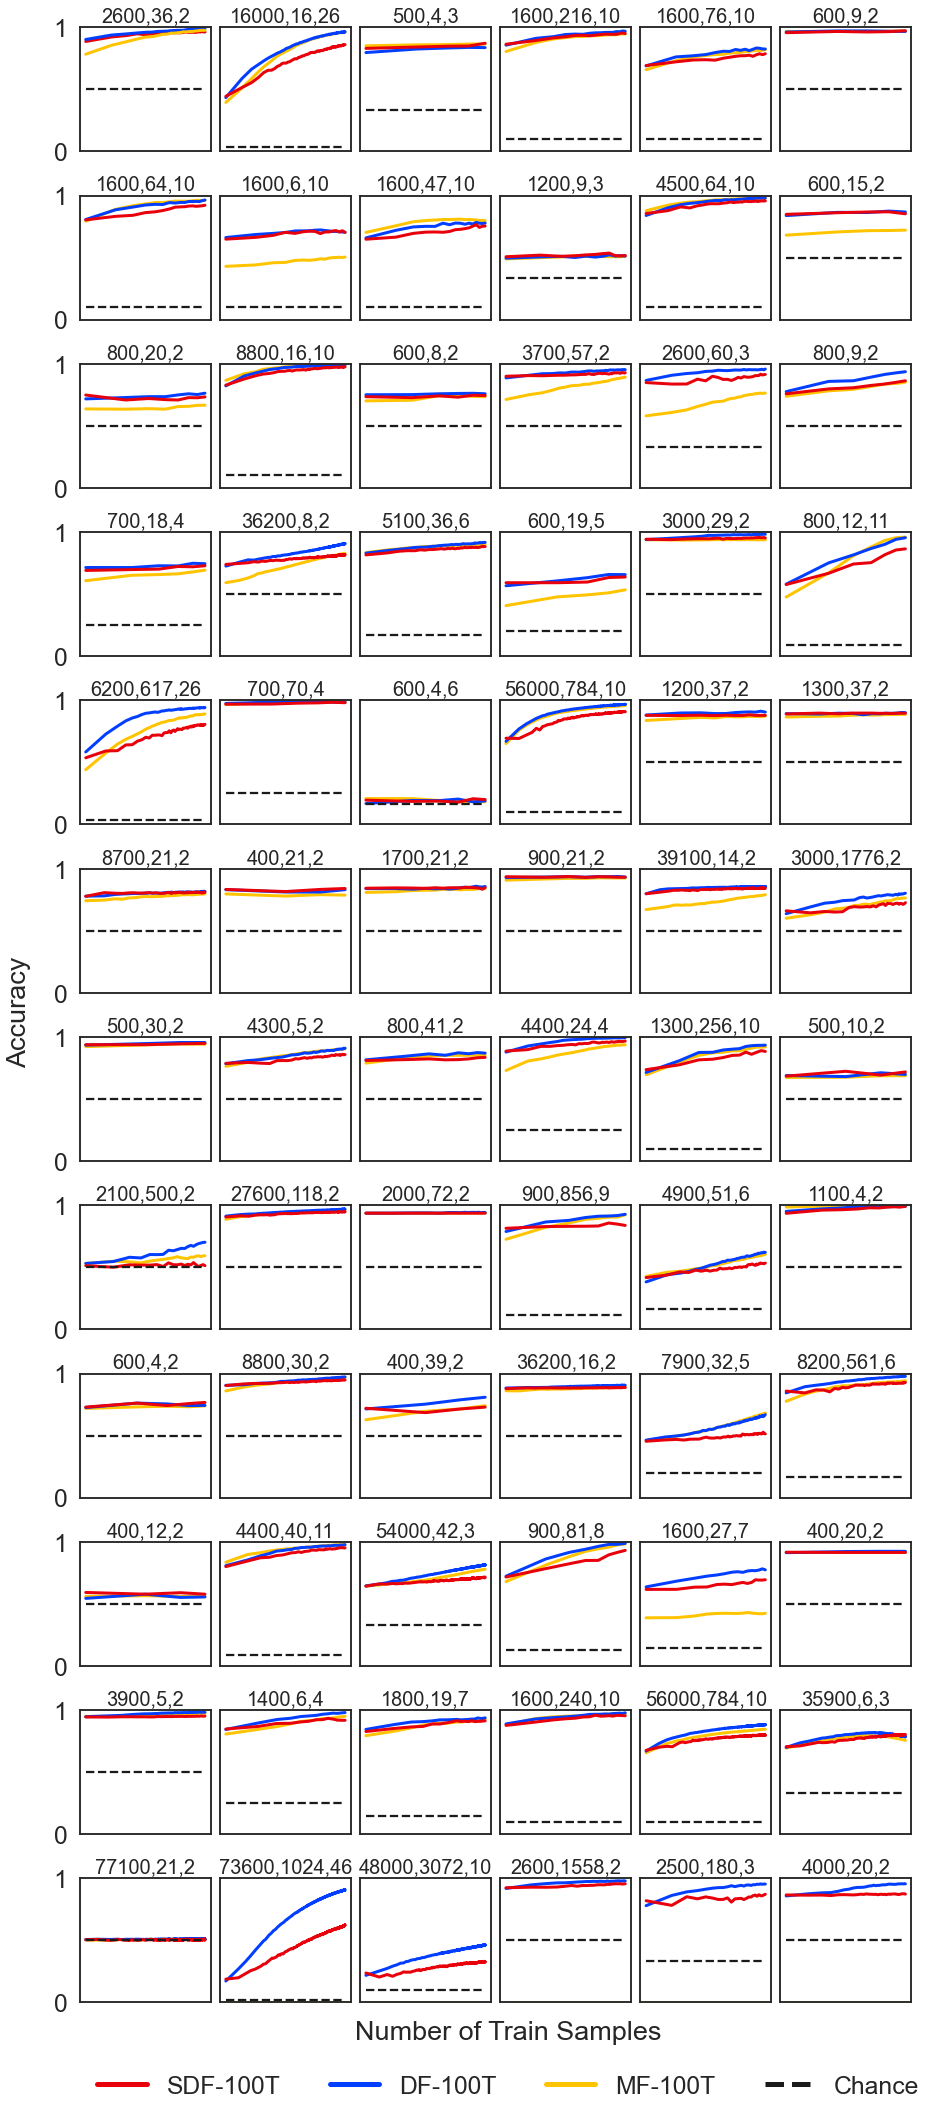

In [6]:
fig, ax = plt.subplots(nrows=12, ncols=6, figsize=(12, 28), constrained_layout=True)
fig.text(0.53, -0.01, "Number of Train Samples", ha="center")
fig.text(-0.05, 0.5, "Accuracy", va="center", rotation="vertical")
ytitles = ["Accuracy", "Wall Time (s)"]
ylimits = [[0, 1], [1e-4, 1e5]]
yticks = [[0, 1], [1e-4, 1e-1, 1e2, 1e5]]

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        count = 6 * i + j
        n_train = range(100, (ranges[count] + 1) * 100, 100)

        # Label x axis and plot figures
        plot_acc(col, acc_ls, count, n_train, lw=3)

        # Plot chance accuracy
        if count == 0:
            col.plot(
                n_train,
                np.repeat(1 / num_classes[count], len(n_train)),
                c=colors[-1],
                linestyle="--",
                label="Chance",
            )
        else:
            col.plot(
                n_train,
                np.repeat(1 / num_classes[count], len(n_train)),
                c=colors[-1],
                linestyle="--",
            )

        # Adjust x axis
        col.set_xscale("log")
        col.tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=False
        )

        # Adjust y axis
        col.set_ylim(ylimits[0])
        if j == 0:
            col.set_yticks(yticks[0])
        else:
            col.set_yticks([])

        # Adjust overall
        col.set_title(
            str(max_size[count])
            + ","
            + str(num_features[count])
            + ","
            + str(num_classes[count]),
            fontsize=20,
        )


fig.align_ylabels(
    ax[
        :,
    ]
)

leg = fig.legend(
    bbox_to_anchor=(0.53, -0.05),
    bbox_transform=plt.gcf().transFigure,
    ncol=4,
    loc="lower center",
)
leg.get_frame().set_linewidth(0.0)
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)
plt.savefig("../paper/cc18.pdf", transparent=True, bbox_inches="tight")

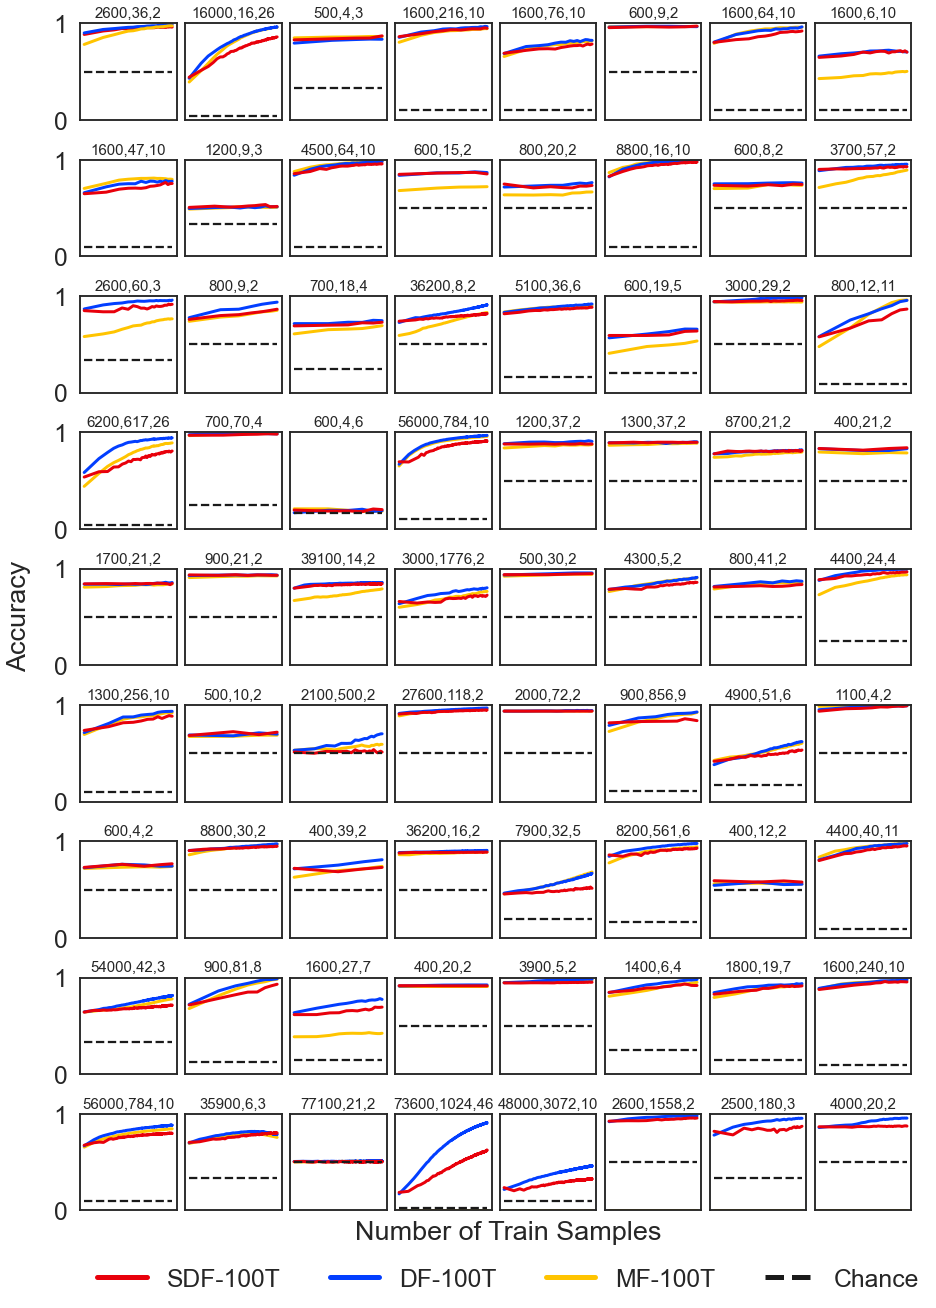

In [7]:
# Plot a wider version
fig, ax = plt.subplots(nrows=9, ncols=8, figsize=(12, 17), constrained_layout=True)
fig.text(0.53, -0.01, "Number of Train Samples", ha="center")
fig.text(-0.05, 0.5, "Accuracy", va="center", rotation="vertical")
ytitles = ["Accuracy", "Wall Time (s)"]
ylimits = [[0, 1], [1e-4, 1e5]]
yticks = [[0, 1], [1e-4, 1e-1, 1e2, 1e5]]

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        count = 8 * i + j
        n_train = range(100, (ranges[count] + 1) * 100, 100)

        # Label x axis and plot figures
        plot_acc(col, acc_ls, count, n_train, lw=3)

        # Plot chance accuracy
        if count == 0:
            col.plot(
                n_train,
                np.repeat(1 / num_classes[count], len(n_train)),
                c=colors[-1],
                linestyle="--",
                label="Chance",
            )
        else:
            col.plot(
                n_train,
                np.repeat(1 / num_classes[count], len(n_train)),
                c=colors[-1],
                linestyle="--",
            )

        # Adjust x axis
        col.set_xscale("log")
        col.tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=False
        )

        # Adjust y axis
        col.set_ylim(ylimits[0])
        if j == 0:
            col.set_yticks(yticks[0])
        else:
            col.set_yticks([])

        # Adjust overall
        col.set_title(
            str(max_size[count])
            + ","
            + str(num_features[count])
            + ","
            + str(num_classes[count]),
            fontsize=15,
        )


fig.align_ylabels(
    ax[
        :,
    ]
)

leg = fig.legend(
    bbox_to_anchor=(0.53, -0.07),
    bbox_transform=plt.gcf().transFigure,
    ncol=4,
    loc="lower center",
)
leg.get_frame().set_linewidth(0.0)
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)
plt.savefig("../paper/cc18_wide.pdf", transparent=True, bbox_inches="tight")

## Plot accuracy (filled) on filtered datasets: SDF & DF

In [5]:
rf_acc_dict = json.load(open(directory + "rf/cc18_acc.json"))
sdf_acc_dict = json.load(open(directory + "sdf/cc18_acc.json"))
avg_rf_acc_ls = []
avg_sdf_acc_ls = []

for dataset in datasets:
    avg_rf_acc_l = np.mean(rf_acc_dict[str(dataset)], axis=0)
    avg_rf_acc_ls.append(avg_rf_acc_l)

    avg_sdf_acc_l = np.mean(sdf_acc_dict[str(dataset)], axis=0)
    avg_sdf_acc_ls.append(avg_sdf_acc_l)

avg_rf_acc_ls = np.array(avg_rf_acc_ls, dtype=object)
avg_sdf_acc_ls = np.array(avg_sdf_acc_ls, dtype=object)

In [9]:
ratio_ls = 100 * (avg_sdf_acc_ls - avg_rf_acc_ls) / avg_rf_acc_ls

eff_filter = []
for i in range(len(ratio_ls)):
    if np.amax(ratio_ls[i]) <= 5 and np.amin(ratio_ls[i]) >= -5:
        eff_filter.append(False)
    else:
        eff_filter.append(True)

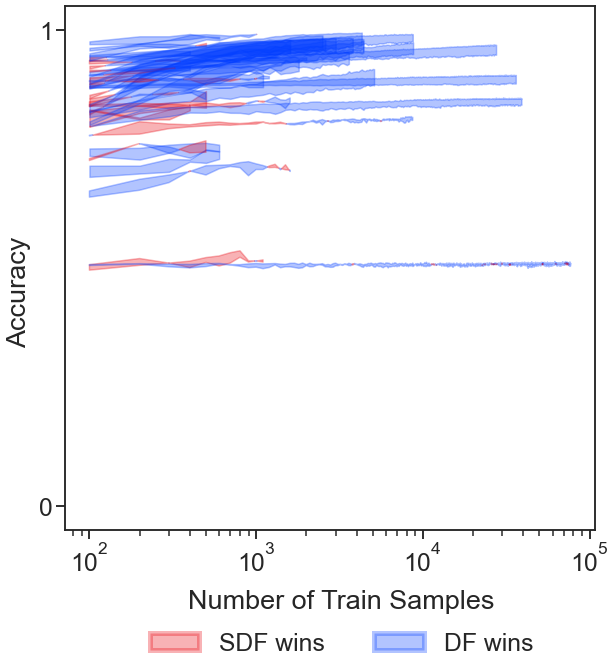

In [10]:
sns.set_theme(style="ticks", palette="bright", context="talk", font_scale=1.5)
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
fig.text(0.53, -0.05, "Number of Train Samples", ha="center")
fig.text(-0.05, 0.5, "Accuracy", va="center", rotation="vertical")
ylimits = [[-0.05, 1.05]]

label = True
for i in range(len(datasets)):
    n_train = range(100, (ranges[i] + 1) * 100, 100)

    if not eff_filter[i]:
        # Label x axis and plot figures
        label = plot_fill(ax, avg_rf_acc_ls[i], avg_sdf_acc_ls[i], label, n_train)

# Adjust x axis
ax.set_xscale("log")

# Adjust y axis
ax.set_ylim(ylimits[0])
ax.set_yticks(yticks[0])

# Adjust overall
leg = fig.legend(
    bbox_to_anchor=(0.53, -0.17),
    bbox_transform=plt.gcf().transFigure,
    ncol=3,
    loc="lower center",
)
leg.get_frame().set_linewidth(0.0)
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)
plt.savefig("../paper/cc18_df_fill.pdf", transparent=True, bbox_inches="tight")

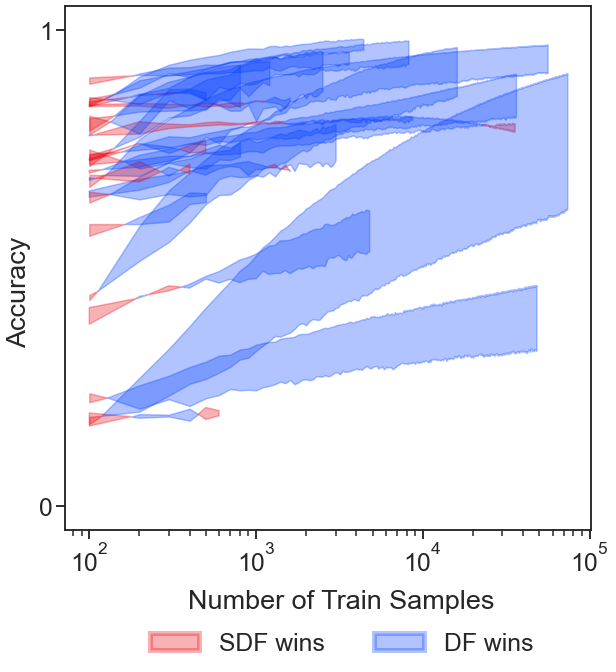

In [10]:
sns.set_theme(style="ticks", palette="bright", context="talk", font_scale=1.5)
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
fig.text(0.53, -0.05, "Number of Train Samples", ha="center")
fig.text(-0.05, 0.5, "Accuracy", va="center", rotation="vertical")
ylimits = [[-0.05, 1.05]]

label = True
for i in range(len(datasets)):
    n_train = range(100, (ranges[i] + 1) * 100, 100)

    if not eff_filter[i]:
        # Label x axis and plot figures
        label = plot_fill(ax, avg_rf_acc_ls[i], avg_sdf_acc_ls[i], label, n_train)

# Adjust x axis
ax.set_xscale("log")

# Adjust y axis
ax.set_ylim(ylimits[0])
ax.set_yticks(yticks[0])

# Adjust overall
leg = fig.legend(
    bbox_to_anchor=(0.53, -0.17),
    bbox_transform=plt.gcf().transFigure,
    ncol=3,
    loc="lower center",
)
leg.get_frame().set_linewidth(0.0)
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)
plt.savefig("../paper/cc18_fill.pdf", transparent=True, bbox_inches="tight")

## Plot accuracy (filled) on filtered datasets: SDF & MF

In [6]:
mf_acc_dict = json.load(open(directory + "mf/cc18_acc.json"))
avg_mf_acc_ls = []

for dataset in datasets:
    try:
        avg_mf_acc_l = np.mean(mf_acc_dict[str(dataset)], axis=0)
    except KeyError:
        data = openml.datasets.get_dataset(dataset, download_data=False)
        num_samples = round(data.qualities["NumberOfInstances"] * 0.8)
        avg_mf_acc_l = np.zeros(int(num_samples / 100))

    avg_mf_acc_ls.append(avg_mf_acc_l)

avg_mf_acc_ls = np.array(avg_mf_acc_ls, dtype=object)

In [7]:
ratio_ls = 100 * (avg_sdf_acc_ls - avg_mf_acc_ls) / avg_mf_acc_ls

eff_filter = []
for i in range(len(ratio_ls)):
    if np.amax(ratio_ls[i]) <= 100 and np.amin(ratio_ls[i]) >= -10:
        eff_filter.append(False)
    else:
        eff_filter.append(True)

<ipython-input-7-622fb9bbf05c>:1: RuntimeWarning: divide by zero encountered in true_divide
  ratio_ls = 100 * (avg_sdf_acc_ls - avg_mf_acc_ls) / avg_mf_acc_ls


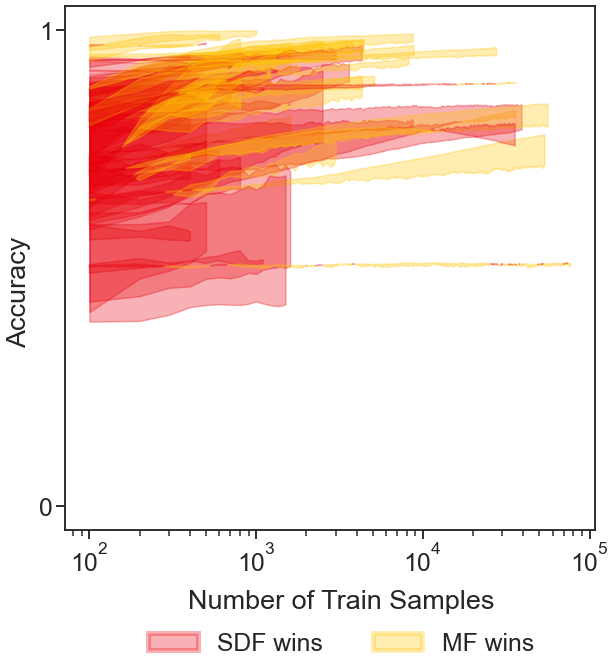

In [20]:
sns.set_theme(style="ticks", palette="bright", context="talk", font_scale=1.5)
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
fig.text(0.53, -0.05, "Number of Train Samples", ha="center")
fig.text(-0.05, 0.5, "Accuracy", va="center", rotation="vertical")
ylimits = [[-0.05, 1.05]]

label = True
for i in range(len(datasets)):
    n_train = range(100, (ranges[i] + 1) * 100, 100)

    if not eff_filter[i]:
        # Label x axis and plot figures
        label = plot_fill(
            ax, avg_mf_acc_ls[i], avg_sdf_acc_ls[i], label, n_train, clf_b=2
        )

# Adjust x axis
ax.set_xscale("log")

# Adjust y axis
ax.set_ylim(ylimits[0])
ax.set_yticks(yticks[0])

# Adjust overall
leg = fig.legend(
    bbox_to_anchor=(0.53, -0.17),
    bbox_transform=plt.gcf().transFigure,
    ncol=2,
    loc="lower center",
)
leg.get_frame().set_linewidth(0.0)
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)
plt.savefig("../paper/cc18_mf_fill.pdf", transparent=True, bbox_inches="tight")

In [8]:
avg_acc_diff = {}
acc_ind = []

for i, dataset in enumerate(datasets):

    if not sum(avg_mf_acc_ls[i]):
        continue
    acc_ind.append(i)
    avg_acc_diff[i] = avg_sdf_acc_ls[i] - avg_mf_acc_ls[i]

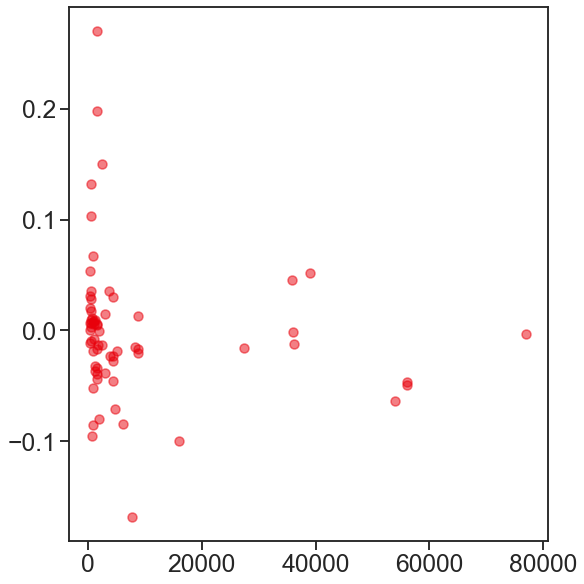

In [59]:
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
for i in acc_ind:
    n_train = range(100, (ranges[i] + 1) * 100, 100)
    ax.scatter(n_train[-1], avg_acc_diff[i][-1], c="r", alpha=0.5)

In [23]:
avg_diff = []

for i in range(800):
    diff = []
    for l in avg_acc_diff:
        try:
            diff.append(avg_acc_diff[l][i])
        except:
            pass

    if len(diff):
        avg_diff.append(sum(diff) / len(diff))

In [25]:
len(avg_diff)

770

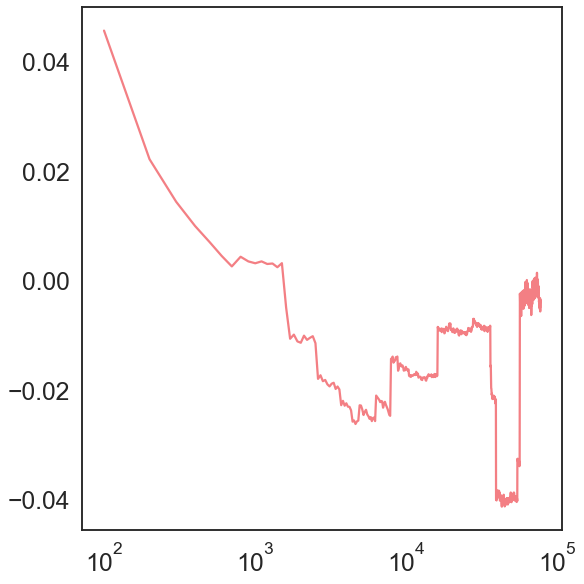

In [28]:
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
ax.set_xscale("log")

n_train = range(100, (len(avg_diff) + 1) * 100, 100)
ax.plot(n_train, avg_diff, c="r", alpha=0.5)

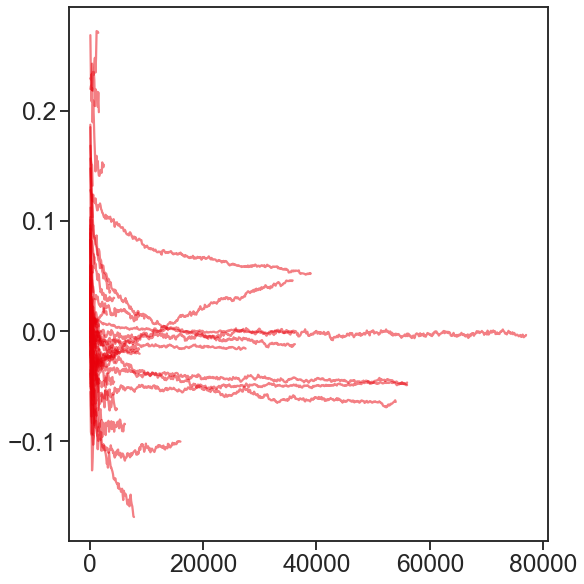

In [66]:
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
for i in acc_ind:
    n_train = range(100, (ranges[i] + 1) * 100, 100)
    ax.plot(n_train, avg_acc_diff[i], c="r", alpha=0.5)

In [46]:
end_acc_diff = []
for i in acc_ind:
    end_acc_diff.append(avg_acc_diff[i][-1])

(array([ 1.,  5., 15., 32.,  9.,  1.,  2.,  1.,  1.]),
 array([-0.1685408 , -0.1197624 , -0.07098399, -0.02220559,  0.02657282,
         0.07535122,  0.12412963,  0.17290803,  0.22168644,  0.27046485]),
 <BarContainer object of 9 artists>)

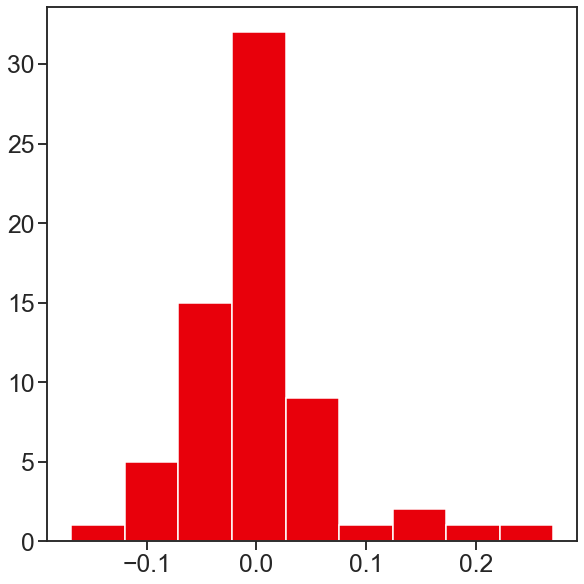

In [58]:
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
ax.hist(end_acc_diff, bins=9, color=["r"])

In [63]:
import scipy

scipy.stats.ttest_1samp(end_acc_diff, popmean=0, alternative="greater")

TtestResult(statistic=-0.1009753494395439, pvalue=0.45993807666823483, df=66)